In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [76]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate

## se1.4: Stirling's approximation

(a) Calculate $\log (n!)$, the approximation $\log (n!) \approx n \log n - n + \frac{1}{2} \log (2 \pi n)$, and simpler approximation $\log (n!) \approx n \log n - n$ for $n \in \{2, 4, 1024, 6.02 \times 10^{23} \}$, and discuss the percent accurcay:

In [6]:
def log_n_factorial(n):
    return sum(map(np.log, range(1, int(n) + 1)))

def simple_stirling_approx(n):
    return n * np.log(n) - n

def stirling_approx(n):
    return simple_stirling_approx(n) + 0.5 * np.log(2 * np.pi * n)


results = []
for n in (2, 4, 1024, 2 ** 16):
    log_fact = log_n_factorial(n)
    approx = stirling_approx(n)
    approx_accuracy = 1 - abs(log_fact - approx) / log_fact
    simple_approx = simple_stirling_approx(n)
    simple_approx_accuracy = 1 - abs(log_fact - simple_approx) / log_fact
    results.append((n, log_fact, approx, approx_accuracy, simple_approx, simple_approx_accuracy))
    
headers = ('n', 'log(n!)', 'Stirling\'s', '%-accuracy', 'Simple', '%-accuracy') 

print(tabulate.tabulate(results, headers, 'fancy_grid'))

╒═══════╤═══════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│     n │       log(n!) │    Stirling's │   %-accuracy │        Simple │   %-accuracy │
╞═══════╪═══════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│     2 │      0.693147 │      0.651806 │     0.940358 │     -0.613706 │    -0.88539  │
├───────┼───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│     4 │      3.17805  │      3.15726  │     0.993458 │      1.54518  │     0.486202 │
├───────┼───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│  1024 │   6078.21     │   6078.21     │     1        │   6073.83     │     0.999279 │
├───────┼───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ 65536 │ 661288        │ 661288        │     1        │ 661281        │     0.99999  │
╘═══════╧═══════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


(c) Draw a bar chart of $\log(n)$ and $\log(\text{ceil}(m))$, argue about the connection to the previous problems

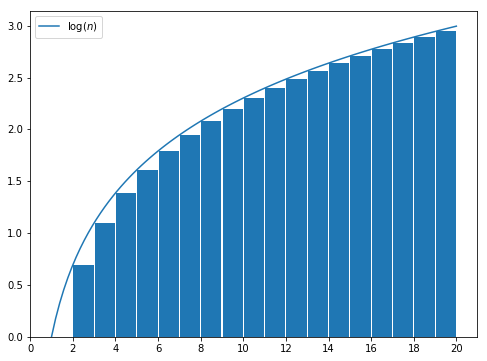

In [31]:
fig = plt.figure(figsize=(8, 6))

x_max = 20

x_cont = np.linspace(1, x_max, x_max * 5)
plt.plot(x_cont, np.log(x_cont), label=r'$\log(n)$')

x = np.arange(1, x_max)
y = np.log(x)
plt.bar(x + 0.5, y, width=0.95)

plt.xticks(np.arange(0, 22, 2))
plt.legend(loc='best')


## sb2.11: stock market

(a) Plot the price index vs. time:

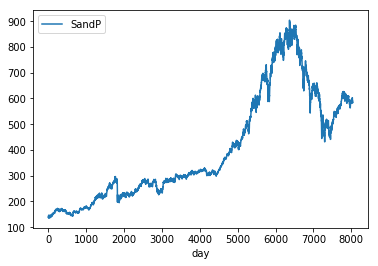

In [46]:
df = pd.read_csv('./SandPConstantDollars.dat', sep='\s+', header=None, names=('day', 'SandP',))
df[:10]
df.plot(x='day', y='SandP')

(b) Histogram of daily, weekly, and yearly changes:

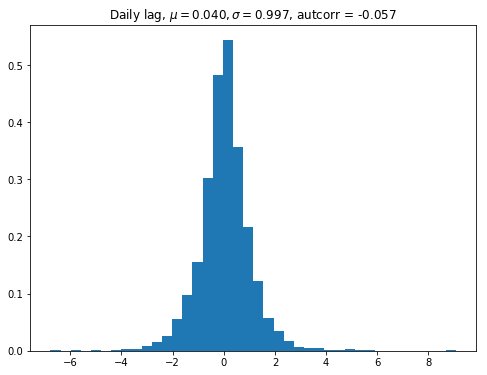

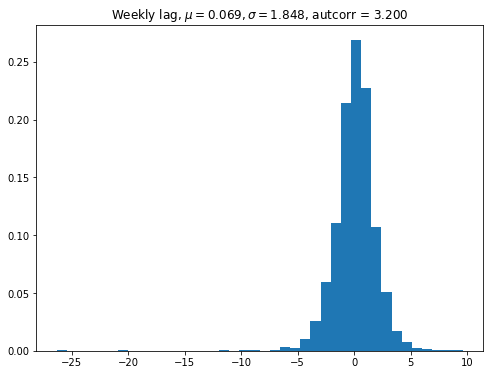

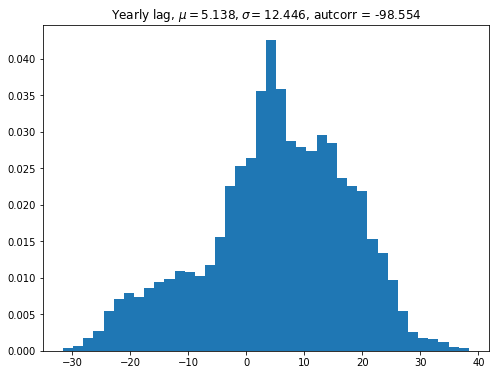

In [72]:
data_dict = {df['day'][i]: df['SandP'][i] for i in range(len(df))}

def compute_lag_precent_change(lag):
    return [100 * (data_dict[d + lag] - data_dict[d]) / data_dict[d]
           for d in data_dict
           if d + lag in data_dict]

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[0]

for lag, title in zip((1, 5, 252), ('Daily lag', 'Weekly lag', 'Yearly lag')):
    fig = plt.figure(figsize=(8, 6))
    lag_changes = compute_lag_precent_change(lag)
    plt.hist(lag_changes, bins=40, density=True)
    plt.title(f'{title}, $\\mu = {np.mean(lag_changes):.3f}, \\sigma = {np.std(lag_changes):.3f}$, autcorr = {autocorr(lag_changes):.3f}')
    plt.show()


(c) log-histogram of weekly %-changes:

/Users/guydavidson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/guydavidson/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


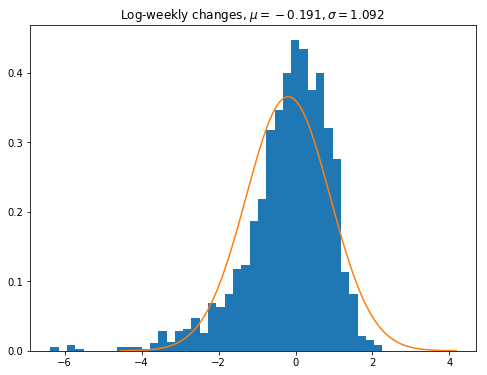

In [81]:
fig = plt.figure(figsize=(8, 6))
lag_changes = compute_lag_precent_change(5)
log_lag_changes = np.log(lag_changes)
plt.hist(log_lag_changes, bins=40, density=True)

mu = np.nanmean(log_lag_changes)
sigma = np.nanstd(log_lag_changes)
dist = stats.norm(mu, sigma)

gaussian_x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, num=100)
plt.plot(gaussian_x, dist.pdf(gaussian_x))

plt.title(f'Log-weekly changes, $\\mu = {mu:.3f}, \\sigma = {sigma:.3f}$ ')
plt.show()


(d) Compute the volatility at different lags:

In [84]:
def volatility(lag):
    lag_percent_changes = compute_lag_precent_change(lag)
    mean_percent_change = np.mean(lag_percent_changes)
    return np.sqrt(np.mean(np.power(lag_percent_changes - mean_percent_change, 2)))

print('Volatility at different lags:')
results = []
for lag, title in zip((1, 5, 21), ('Daily lag', 'Weekly lag', 'Monthly lag')):
    v = volatility(lag)
    results.append((lag, title, v, v ** 2))
    
headers = ('Lag', 'Name', 'Volatility', 'Squared Volatility ') 

print(tabulate.tabulate(results, headers, 'fancy_grid'))

Volatility at different lags:
╒═══════╤═════════════╤══════════════╤═══════════════════════╕
│   Lag │ Name        │   Volatility │   Squared Volatility  │
╞═══════╪═════════════╪══════════════╪═══════════════════════╡
│     1 │ Daily lag   │      0.99705 │               0.99411 │
├───────┼─────────────┼──────────────┼───────────────────────┤
│     5 │ Weekly lag  │      1.84814 │               3.41561 │
├───────┼─────────────┼──────────────┼───────────────────────┤
│    21 │ Monthly lag │      3.68753 │              13.5979  │
╘═══════╧═════════════╧══════════════╧═══════════════════════╛


Volatility as a function of lags:

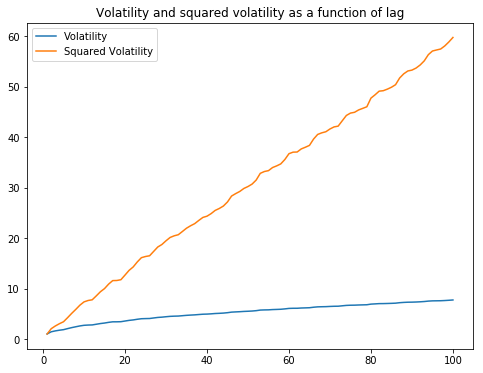

In [85]:
fig = plt.figure(figsize=(8, 6))

lags = np.arange(1, 101)
volatilities = np.array([volatility(lag) for lag in lags])

plt.plot(lags, volatilities, label='Volatility')
plt.plot(lags, volatilities ** 2, label='Squared Volatility')

plt.title(f'Volatility and squared volatility as a function of lag')
plt.legend(loc='best')
plt.show()
